In [1]:

import pandas as pd
import nltk
import string
from gensim.models import Word2Vec
import numpy as np
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import  classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


In [41]:
FINE_TUNED_DIR = '../../pretained_or_finetune-models'
REVIEWS_DATASET_DIR = '../../dataset'
UTILS_DIR = '../../utils'
NLTK_DATA_PATH = f"{FINE_TUNED_DIR}/nltk_data"
DIR_MODEL_STORED = f"../../models/Hybrid-CNN-LSTM_models_sample.h5"

nltk.data.path.append(NLTK_DATA_PATH)

In [3]:
tourism_reviews_en = pd.read_csv(f"{REVIEWS_DATASET_DIR}/eng_reviews_emotion_classify.csv", encoding='utf-8')

columns_to_use = ['helpful_votes', 'location_id', 'review_id', 'review',
                  'review_subject', 'trip_type', 'rating',
                  'location_name', 'province', 'place_id', 'emotion', 'cleaned_review']
columns_to_train = ['location_id', 'review', 'rating']
review_df = tourism_reviews_en[columns_to_use]

In [4]:
tourism_reviews_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5909 entries, 0 to 5908
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0.1    5909 non-null   int64 
 1   Unnamed: 0      5909 non-null   int64 
 2   helpful_votes   5909 non-null   int64 
 3   location_id     5909 non-null   int64 
 4   lang            5909 non-null   object
 5   review_id       5909 non-null   int64 
 6   review          5909 non-null   object
 7   review_subject  5909 non-null   object
 8   trip_type       5892 non-null   object
 9   travel_date     5892 non-null   object
 10  rating          5909 non-null   int64 
 11  location_name   5909 non-null   object
 12  province        5909 non-null   object
 13  place_id        5909 non-null   object
 14  cleaned_review  5909 non-null   object
 15  emotion         5909 non-null   object
dtypes: int64(6), object(10)
memory usage: 738.8+ KB


In [5]:
review_df.describe()

,helpful_votes,location_id,review_id,rating
count,5909.000000,5.909000e+03,5.909000e+03,5909.000000
mean,1.058216,6.483167e+06,7.590446e+08,4.153833
std,5.625108,4.877561e+06,1.844114e+08,1.067077
min,0.000000,3.110380e+05,1.049076e+08,1.000000
25%,0.000000,2.578107e+06,6.573250e+08,4.000000
50%,0.000000,6.017599e+06,7.832754e+08,4.000000
75%,1.000000,8.818088e+06,9.240324e+08,5.000000
max,182.000000,2.714283e+07,9.653184e+08,5.000000


In [6]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5909 entries, 0 to 5908
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   helpful_votes   5909 non-null   int64 
 1   location_id     5909 non-null   int64 
 2   review_id       5909 non-null   int64 
 3   review          5909 non-null   object
 4   review_subject  5909 non-null   object
 5   trip_type       5892 non-null   object
 6   rating          5909 non-null   int64 
 7   location_name   5909 non-null   object
 8   province        5909 non-null   object
 9   place_id        5909 non-null   object
 10  emotion         5909 non-null   object
 11  cleaned_review  5909 non-null   object
dtypes: int64(4), object(8)
memory usage: 554.1+ KB


In [7]:
review_df

,helpful_votes,location_id,review_id,review,review_subject,trip_type,rating,location_name,province,place_id,emotion,cleaned_review
0,0,2209612,953596359,Besides elegant grand palace and wat pra kaew ...,"The place is nearby grand palace, in the area ...",Family,5,Wat Ratchabophit,Bangkok,P03013220,joy,besides elegant grand palace <OOV> wat pra kae...
1,0,2209612,938998692,This is one of the last big king temples of Ba...,Nice Wat,Solo travel,4,Wat Ratchabophit,Bangkok,P03013220,joy,<OOV> <OOV> one <OOV> <OOV> last big king temp...
2,6,2209612,933065689,"It is beautiful, clean and free to enter. Both...",Nice views,Solo travel,4,Wat Ratchabophit,Bangkok,P03013220,joy,<OOV> <OOV> beautiful clean <OOV> free <OOV> e...
3,0,2209612,885904967,Wat Ratchabophit is a Buddhist temple located ...,Wat Ratchabophit - a temple characterized by u...,Couples,5,Wat Ratchabophit,Bangkok,P03013220,joy,wat ratchabophit <OOV> <OOV> buddhist temple l...
4,4,2209612,782967555,Wat Ratchabophit is a historic royal temple bu...,"Beautiful, peaceful",NONE,5,Wat Ratchabophit,Bangkok,P03013220,joy,wat ratchabophit <OOV> <OOV> historic royal te...
...,...,...,...,...,...,...,...,...,...,...,...,...
5904,0,1831068,888281929,Is quite far from Korat Town or main highway. ...,Can visit.. depends on individual,Family,3,Prasat Puay Noi,Nonthaburi,P03013503,joy,<OOV> quite far <OOV> korat town <OOV> main hi...
5905,4,1831068,752115552,Prasat Pueai Noi is claimed to be the biggest ...,"Small, Isolated Khmer Sanctuary",NONE,3,Prasat Puay Noi,Nonthaburi,P03013503,joy,prasat pueai noi <OOV> claimed <OOV> <OOV> <OO...
5906,0,1831068,693354319,I think this place is claimed to be the oldest...,A sense of ancient times..,Friends getaway,4,Prasat Puay Noi,Nonthaburi,P03013503,joy,<OOV> think <OOV> place <OOV> claimed <OOV> <O...
5907,1,1831068,573376614,The compound comprises three brick buildings o...,Another Angkor Wat,Solo travel,4,Prasat Puay Noi,Nonthaburi,P03013503,joy,<OOV> compound comprises three brick buildings...


In [8]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

custom_stopwords = set(stopwords.words('english'))
stop_words = custom_stopwords
lemmatizer = WordNetLemmatizer()

In [9]:
def advanced_clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters
    text = re.sub(r'\b(u|ur|b4)\b', 'you', text)  # Replace common abbreviations
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    words = [word for word in words if word not in string.punctuation]
    return ' '.join(words)

In [10]:
# Apply preprocessing to the review texts
review_df['cleaned_review'] = review_df['review'].apply(advanced_clean_text)

# 2. สร้าง Word Embeddings ด้วย Word2Vec
sentences = [row.split() for row in review_df['cleaned_review']]
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)  # เปลี่ยน vector_size เป็น 300



/var/folders/fk/449tdf_12hzd2r7ps4659q0m0000gn/T/ipykernel_46555/994389100.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['cleaned_review'] = review_df['review'].apply(advanced_clean_text)


In [11]:
# Parameters
embedding_dim = 300  # Assuming Word2Vec has 300 dimensions
dropout_rate = 0.5
num_classes = 1  # Binary classification
max_len = 100  # Maximum length of input sequences
ngram_range = (1, 2)  # Unigrams and bigrams
max_features = 20000  

# Create the embedding matrix from the Word2Vec model
word_index = {word: i for i, word in enumerate(word2vec_model.wv.index_to_key)}
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

In [12]:
def text_to_word2vec(tokens, model, max_length=300):
    vector = np.zeros((max_length, 300))
    for i, word in enumerate(tokens):
        if i < max_length:
            if word in model.wv:
                vector[i] = model.wv[word]
    return vector

review_df['embedding'] = review_df['cleaned_review'].apply(lambda x: text_to_word2vec(x, word2vec_model))


/var/folders/fk/449tdf_12hzd2r7ps4659q0m0000gn/T/ipykernel_46555/1367629667.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['embedding'] = review_df['cleaned_review'].apply(lambda x: text_to_word2vec(x, word2vec_model))


In [13]:
def map_rating_to_sentiment(rating):
    if rating in [1, 2]:
        return 'negative'
    elif rating in [3, 4]:
        return 'neutral'
    else:  # 4 or 5
        return 'positive'

review_df['sentiment'] = review_df['rating'].apply(map_rating_to_sentiment)

/var/folders/fk/449tdf_12hzd2r7ps4659q0m0000gn/T/ipykernel_46555/2638035927.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['sentiment'] = review_df['rating'].apply(map_rating_to_sentiment)


In [14]:
from sklearn.utils import resample

# Assuming `review_df` is your original DataFrame with a 'sentiment' column

# 1. Separate the data by class
df_positive = review_df[review_df.sentiment == 'positive']
df_neutral = review_df[review_df.sentiment == 'neutral']
df_negative = review_df[review_df.sentiment == 'negative']

# 2. Resample the minority classes
# For example, oversample the neutral and negative classes to match the positive class
df_neutral_upsampled = resample(df_neutral,
                                replace=True,  # Sample with replacement
                                n_samples=len(df_positive),  # Match number of positive class samples
                                random_state=42)  # Reproducible results

df_negative_upsampled = resample(df_negative,
                                 replace=True,  # Sample with replacement
                                 n_samples=len(df_positive),  # Match number of positive class samples
                                 random_state=42)  # Reproducible results

# 3. Combine the resampled DataFrames
df_balanced = pd.concat([df_positive, df_neutral_upsampled, df_negative_upsampled])

# 4. Shuffle the combined DataFrame
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# 5. Check the distribution of the classes
print(df_balanced['sentiment'].value_counts())


sentiment
neutral     2871
positive    2871
negative    2871
Name: count, dtype: int64


In [15]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df_balanced['cleaned_review'])

X = tokenizer.texts_to_sequences(df_balanced['cleaned_review'])
X = pad_sequences(X, maxlen=max_len)

# แปลงคอลัมน์ 'sentiment' เป็นข้อมูลตัวเลข
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
y = df_balanced['sentiment'].map(label_mapping)

In [16]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

# แบ่งข้อมูลใหม่อีกครั้งหลังจาก SMOTE
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

In [17]:
# Check the shapes of the resulting arrays
print(f"X_train shape: {X_train_resampled.shape}")
print(f"y_train shape: {y_train_resampled.shape}")
print(f"X_test shape: {X_val.shape}")
print(f"y_test shape: {y_val.shape}")


X_train shape: (6890, 100)
y_train shape: (6890,)
X_test shape: (1723, 100)
y_test shape: (1723,)


In [18]:
y_val

4205    2
1665    1
3121    2
3126    2
3688    0
       ..
8510    1
7445    2
2132    0
247     1
4011    2
Name: sentiment, Length: 1723, dtype: int64

In [23]:
X_val

array([[   0,    0,    0, ..., 1245,  124, 1254],
       [   0,    0,    0, ..., 1568, 1321, 2532],
       [   0,    0,    0, ...,  272,  345, 1360],
       ...,
       [   0,    0,    0, ...,  426,   19,  651],
       [   0,    0,    0, ...,  193,  497, 1004],
       [   0,    0,    0, ..., 4532,  165, 1071]], dtype=int32)

In [49]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dense, Dropout
import numpy as np

# Parameters
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout

# Parameters
vocab_size = 20000  # จำนวนคำที่คุณใช้ใน embedding
embedding_dim = 100  # ขนาดของ embedding vector
sequence_length = X_train_resampled.shape[1]  # จำนวนคำในแต่ละประโยค

# สร้างโมเดล
model_cnn_lstm = Sequential()

# Embedding layer: แปลง tokens (เช่น 1, 2, 3) เป็น embedding vector
model_cnn_lstm.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length))

# Conv1D layer
model_cnn_lstm.add(Conv1D(128, kernel_size=3, activation='relu'))

# MaxPooling1D เพื่อรักษาข้อมูลลำดับ
model_cnn_lstm.add(MaxPooling1D(pool_size=2))

# LSTM layer
model_cnn_lstm.add(LSTM(64))
model_cnn_lstm.add(Dropout(0.5))

# Fully connected layer
model_cnn_lstm.add(Dense(1, activation='sigmoid'))

# Compile the model
model_cnn_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# แสดงรายละเอียดของโมเดล
model_cnn_lstm.summary()



/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if i < max_features:
        # ใช้ [] แทนการใช้ get() เพื่อดึง embedding vector
        if word in word2vec_model.wv:
            embedding_vector = word2vec_model.wv[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [53]:

from keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping เพื่อหยุดการฝึกหาก validation loss ไม่ลดลงใน 3 epochs ติดต่อกัน
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# ModelCheckpoint เพื่อบันทึกโมเดลที่มีค่าการสูญเสียต่ำสุดใน validation
model_checkpoint = ModelCheckpoint(DIR_MODEL_STORED, monitor='val_loss', save_best_only=True, verbose=1)

# ฝึกโมเดลพร้อมใช้ callbacks
history = model_cnn_lstm.fit(
    X_train_resampled, 
    y_train_resampled,
    epochs=30,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)


Epoch 1/30
106/108 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6594 - loss: -27.6462
Epoch 1: val_loss improved from inf to -28.63317, saving model to ../../models/Hybrid-CNN-LSTM_models_sample.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6595 - loss: -27.6581 - val_accuracy: 0.6465 - val_loss: -28.6332
Epoch 2/30
106/108 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6601 - loss: -30.2632
Epoch 2: val_loss improved from -28.63317 to -30.46948, saving model to ../../models/Hybrid-CNN-LSTM_models_sample.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6602 - loss: -30.2662 - val_accuracy: 0.6483 - val_loss: -30.4695
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6772 - loss: -30.8804
Epoch 3: val_loss improved from -30.46948 to -33.29914, saving model to ../../models/Hybrid-CNN-LSTM_models_sample.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6771 - loss: -30.8961 - val_accuracy: 0.6465 - val_loss: -33.2991
Epoch 4/30

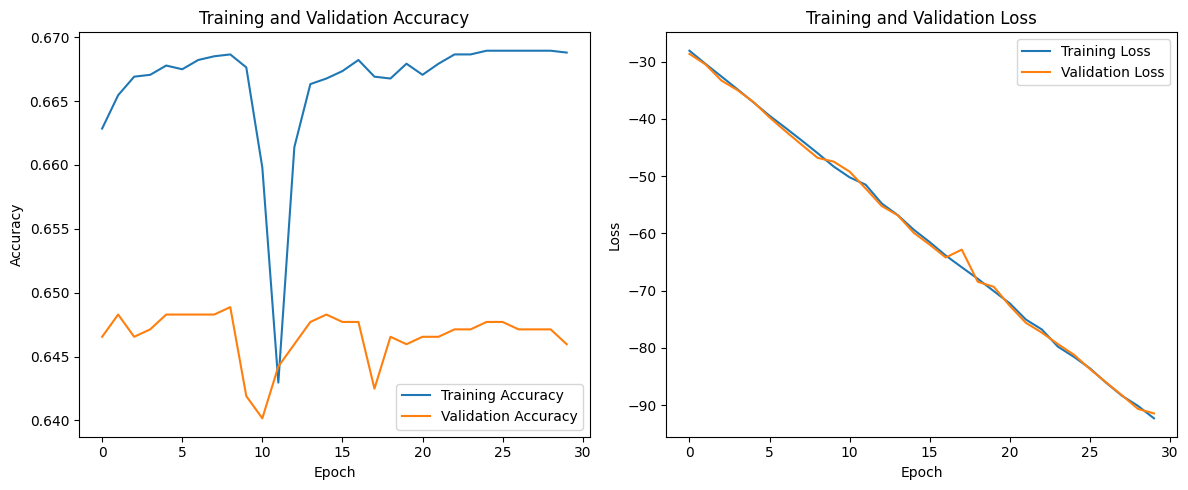

In [54]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']      # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy
loss = history.history['loss']         # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # Create subplot for accuracy
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)  # Create subplot for loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [56]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.models import load_model

# โหลดโมเดล LSTM ที่ดีที่สุด
best_model = load_model(DIR_MODEL_STORED)

In [57]:
# ใช้โมเดล LSTM ทำนายข้อมูล validation set
lstm_preds = best_model.predict(X_val)
lstm_preds = np.argmax(lstm_preds, axis=1)

# ฝึก Gradient Boosting Classifier บนผลลัพธ์จาก LSTM
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_clf.fit(lstm_preds.reshape(-1, 1), y_val)

# ทำนายผลลัพธ์ด้วย Gradient Boosting
ensemble_preds = gb_clf.predict(lstm_preds.reshape(-1, 1))

# ตรวจสอบผลลัพธ์
print(classification_report(y_val, ensemble_preds))
print(confusion_matrix(y_val, ensemble_preds))

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       589
           1       0.00      0.00      0.00       544
           2       0.34      1.00      0.51       590

    accuracy                           0.34      1723
   macro avg       0.11      0.33      0.17      1723
weighted avg       0.12      0.34      0.17      1723

[[  0   0 589]
 [  0   0 544]
 [  0   0 590]]


/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python

In [58]:
lstm_preds = best_model.predict(X_val)
lstm_preds = np.argmax(lstm_preds, axis=1)

print(classification_report(y_val, lstm_preds))
print(confusion_matrix(y_val, lstm_preds))

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

           0       0.34      1.00      0.51       589
           1       0.00      0.00      0.00       544
           2       0.00      0.00      0.00       590

    accuracy                           0.34      1723
   macro avg       0.11      0.33      0.17      1723
weighted avg       0.12      0.34      0.17      1723

[[589   0   0]
 [544   0   0]
 [590   0   0]]


/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python

In [94]:
# สร้างโมเดล Random Forest (Bagging)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
rf_predictions = rf_model.predict(X_val)

# สร้างโมเดล Gradient Boosting (Boosting)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_resampled, y_train_resampled)
gb_predictions = gb_model.predict(X_val)

# วัดผลลัพธ์ของแต่ละโมเดล
print("Random Forest Accuracy:", accuracy_score(y_val, rf_predictions))
print("Gradient Boosting Accuracy:", accuracy_score(y_val, gb_predictions))

Random Forest Accuracy: 0.8276262333139872
Gradient Boosting Accuracy: 0.6604759141033082


In [97]:
# Ensemble วิธี Voting (Hard Voting)
from sklearn.ensemble import VotingClassifier

# รวมโมเดลทั้งสองด้วยการ Voting
voting_model = VotingClassifier(estimators=[
    ('rf', rf_model), ('gb', gb_model)],
    voting='hard')

voting_model.fit(X_train_resampled, y_train_resampled)
voting_predictions = voting_model.predict(X_val)

# วัดผลลัพธ์จากการใช้ Voting
print("Voting Ensemble Accuracy:", accuracy_score(y_val, voting_predictions))

Voting Ensemble Accuracy: 0.6993615786419036


In [98]:
y_val

4205    2
1665    1
3121    2
3126    2
3688    0
       ..
8510    1
7445    2
2132    0
247     1
4011    2
Name: sentiment, Length: 1723, dtype: int64

In [112]:
common_indices = y_val.index.intersection(review_df.index)
missing_indices = y_val.index.difference(review_df.index)
print(f"Common indices count: {len(common_indices)}")
print(f"Missing indices count: {len(missing_indices)}")

Common indices count: 1170
Missing indices count: 553


In [110]:
# y_val = y_val.iloc[:-1]

In [59]:
predict_label = y_val

In [60]:
redicted_df = pd.DataFrame({'predicted': ensemble_preds}, index=y_val.index)
    
    # Concatenate y_val and the new predicted_df to create a new DataFrame
predict_df = pd.concat([y_val, redicted_df], axis=1)

In [61]:
predict_df

,sentiment,predicted
4205,2,2
1665,1,2
3121,2,2
3126,2,2
3688,0,2
...,...,...
8510,1,2
7445,2,2
2132,0,2
247,1,2


In [62]:
valid_y_val = predict_df.loc[predict_df.index.isin(review_df.index)]

# Now you can safely use .loc with valid_y_val indices
filtered_reviews = review_df.loc[valid_y_val.index]

In [63]:
filtered_reviews

,helpful_votes,location_id,review_id,review,review_subject,trip_type,rating,location_name,province,place_id,emotion,cleaned_review,embedding,sentiment
4205,0,11867768,660193827,"The place is a real gem, nestling in the cool ...",Not to be Missed!,Couples,5,The Royal Agricultural Station Angkhang,Phetchabun,P03012884,joy,place real gem nestling cool green upland doi ...,"[[-0.00040356535464525223, 0.08227149397134781...",positive
1665,0,16868178,893223254,"Nice view, but you need to be be careful when ...",Nice view,Friends getaway,5,Chado Cliff Viewpoint,Phra Nakhon Si Ayutthaya,P03017905,joy,nice view need careful hiking natural trail be...,"[[-0.016603266820311546, 0.230815589427948, 0....",positive
3121,1,556614,874997345,Doi Mae Salong is a beautiful and interesting ...,Beautiful and peaceful,NONE,5,Doi Mae Salong,Nakhon Sawan,P03016134,joy,doi mae salong beautiful interesting place vis...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive
3126,0,6669517,632751727,Located on the way we back to our accommodatio...,temple that next to the road,Couples,3,Chedi Phra Borommasaririkkathat Khao Kho,Nakhon Sawan,P03016132,joy,located way back accommodation look time avail...,"[[-0.004376769065856934, 0.06964970380067825, ...",neutral
3688,1,7659431,613000573,i stayed on koh larn at the castello resort ov...,i love this island so much,Solo travel,5,Thong Lang Beach,Sukhothai,P03025214,joy,stayed koh larn castello resort christmas enjo...,"[[3.884751640725881e-05, 0.014010164886713028,...",positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,0,8874054,875897422,Chaio por Phawo Shrine is the most popular pra...,Most Respect shine in Mae sot People,NONE,5,Chao Por Phawo Shrine,Nonthaburi,P03016494,joy,chaio por phawo shrine popular pray respect pl...,"[[-0.009989351965487003, 0.11245451122522354, ...",positive
4129,1,1307603,750690836,Took a fast boat for a magical day at Hapla Be...,Blissful,Couples,5,Koh Kho Khao Island,Phetchabun,P03004050,joy,took fast boat magical day hapla beach real ro...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive
2132,0,554864,696305303,in the twelfe-year animal cycle the rabbit is ...,the rabbit temple,Couples,5,Wat Phrathat Chae Haeng,Sing Buri,P03013402,joy,twelfeyear animal cycle rabbit one wat phra ch...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive
247,0,25571501,929540899,We went on a weekday and was pleased that this...,Best Jodd Fair,Friends getaway,5,Jodd Fairs DanNeramit,Bangkok,P03022261,joy,went weekday pleased jodd fair wasnt packed ma...,"[[-0.0003337457310408354, 0.029664665460586548...",positive


In [79]:
filtered_reviews['helpful_votes']

4205    0
1665    0
3121    1
3126    0
3688    1
       ..
469     0
4129    1
2132    0
247     0
4011    1
Name: helpful_votes, Length: 1170, dtype: int64

In [88]:

predictions_df = pd.DataFrame({
    'location_id': filtered_reviews['location_id'],
    'location_name': filtered_reviews['location_name'],
    'trip_type': filtered_reviews['trip_type'],
    'rating': filtered_reviews['rating'],
    'helpful_voting': filtered_reviews['helpful_votes'].astype(int),
    'review_text': filtered_reviews['review'],  # Assuming X_test is a subset with a specific index
    'actual_sentiment': predict_df['sentiment'],  # The actual sentiment labels
    'predicted_sentiment': predict_df['predicted']  # The predicted sentiment labels
})

# predictions_df['actual_sentiment'] = predictions_df['actual_sentiment'].map(label_mapping)
# predictions_df['predicted_sentiment'] = predictions_df['predicted_sentiment'].map(label_mapping)

predictions_df.head(5)


,location_id,location_name,trip_type,rating,helpful_voting,review_text,actual_sentiment,predicted_sentiment
8,2273363.0,Wat Rajapradit Sathitmahasimaram Rajaworavihara,NONE,5.0,2.0,One of the least crowded temples but very beau...,2,2
14,311043.0,Wat Phra Chetuphon,Couples,5.0,0.0,"The designs, the Buddhas, and other figures fe...",1,2
17,317504.0,Temple Of Dawn (Wat Arun),Solo travel,5.0,15.0,"Known as Temple of Dawn, I went to this temple...",0,2
19,317504.0,Temple Of Dawn (Wat Arun),Family,4.0,0.0,I have to admit that this is a place i have al...,0,2
23,456322.0,Wat Umong,Family,5.0,0.0,The visit to this temple was a good pick for u...,1,2


In [89]:
predictions_df = predictions_df[predictions_df['location_id'].isna() == False]
predictions_df

,location_id,location_name,trip_type,rating,helpful_voting,review_text,actual_sentiment,predicted_sentiment
8,2273363.0,Wat Rajapradit Sathitmahasimaram Rajaworavihara,NONE,5.0,2.0,One of the least crowded temples but very beau...,2,2
14,311043.0,Wat Phra Chetuphon,Couples,5.0,0.0,"The designs, the Buddhas, and other figures fe...",1,2
17,317504.0,Temple Of Dawn (Wat Arun),Solo travel,5.0,15.0,"Known as Temple of Dawn, I went to this temple...",0,2
19,317504.0,Temple Of Dawn (Wat Arun),Family,4.0,0.0,I have to admit that this is a place i have al...,0,2
23,456322.0,Wat Umong,Family,5.0,0.0,The visit to this temple was a good pick for u...,1,2
...,...,...,...,...,...,...,...,...
5858,1390151.0,Herbal Steam House,Couples,3.0,0.0,Hubby and I stopped in for our third massage s...,0,2
5866,6668995.0,Wat Intharam,Friends getaway,2.0,0.0,Wat Intharam was apparently built during the A...,1,2
5880,456191.0,Khuean Srinagarindra National Park,Couples,4.0,1.0,After visiting the nearby waterfalls we drove ...,1,2
5893,4322899.0,Prasat Wat Sa Kamphaeng Yai,Friends getaway,4.0,1.0,On same site as Prasat Wat Sa Kampheang Noi {w...,0,2


In [90]:
predictions_df.describe()

,location_id,rating,helpful_voting,actual_sentiment,predicted_sentiment
count,1.170000e+03,1170.000000,1170.000000,1170.000000,1170.0
mean,6.509009e+06,4.180342,1.269231,0.999145,2.0
std,4.979843e+06,1.037759,7.665828,0.822585,0.0
min,3.110380e+05,1.000000,0.000000,0.000000,2.0
25%,2.450678e+06,4.000000,0.000000,0.000000,2.0
50%,6.154397e+06,4.000000,0.000000,1.000000,2.0
75%,8.844294e+06,5.000000,1.000000,2.000000,2.0
max,2.714283e+07,5.000000,182.000000,2.000000,2.0


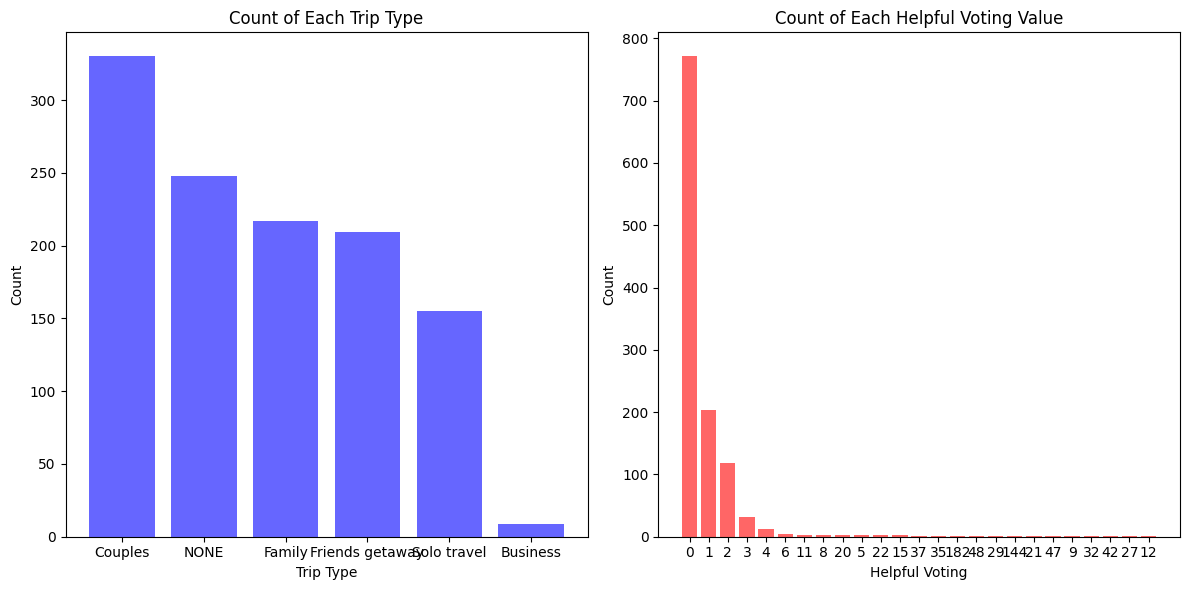

In [91]:
import matplotlib.pyplot as plt

# นับจำนวนแต่ละค่าในคอลัมน์ 'trip_type'
trip_type_counts = predictions_df['trip_type'].value_counts()

# นับจำนวนของแต่ละค่าจาก helpful_voting และแปลงเป็น int
helpful_voting_counts = predictions_df['helpful_voting'].astype(int).value_counts()

# สร้างกราฟสองกราฟในบรรทัดเดียวกัน (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart สำหรับ trip_type
ax1.bar(trip_type_counts.index.astype(str), trip_type_counts.values, color='b', alpha=0.6)
ax1.set_xlabel('Trip Type')
ax1.set_ylabel('Count')
ax1.set_title('Count of Each Trip Type')

# Bar chart สำหรับ helpful_voting
ax2.bar(helpful_voting_counts.index.astype(str), helpful_voting_counts.values, color='r', alpha=0.6)
ax2.set_xlabel('Helpful Voting')
ax2.set_ylabel('Count')
ax2.set_title('Count of Each Helpful Voting Value')

# ปรับระยะห่างของกราฟ
plt.tight_layout()

# แสดงกราฟ
plt.show()


In [66]:
predictions_df.to_csv('./output/Hybrid_CNN-LSTM_predictions.csv')

In [138]:
y_val = y_val.astype(int)
ensemble_preds_class = ensemble_preds.astype(int)


In [139]:
print(y_val.shape)            # Shape of y_val
print(ensemble_preds.shape) 

(1723,)
(1723,)


In [140]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score directly using ensemble_preds
precision = precision_score(y_val, ensemble_preds, average='weighted')
recall = recall_score(y_val, ensemble_preds, average='weighted')
f1 = f1_score(y_val, ensemble_preds, average='weighted')

# Print the results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')


Precision: 0.6930
Recall: 0.6883
F1-Score: 0.6807
